In [1]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import Covid_Init
from Covid_Init import *
import torchvision
from torchvision import datasets, models, transforms

#import optimizerCyclic

1.7.0


In [2]:
import math

from utils_ozan import unetConv2, unetUp, unetUp_cca
from networks_other_ozan import init_weights
#import unet_nonlocal_2D 
#from unet_nonlocal_2D import *

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
class unet_2D(nn.Module):

    def __init__(self, feature_scale=4, n_classes=3, is_deconv=True, in_channels=1, is_batchnorm=True):
        super(unet_2D, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale
        num_classes = 3

        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        #self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        #self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        #self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)   
        self.center = unetConv2(filters[2], filters[3], self.is_batchnorm)   # Changed
        self.head = RCCAModule(filters[3], filters[3], num_classes)

        # upsampling
        #self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
        self.up_concat3 = unetUp_cca(filters[3], filters[2], num_classes,self.is_deconv)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], n_classes, 1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')


    def forward(self, inputs):
        conv1 = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        #conv4 = self.conv4(maxpool3)
        #maxpool4 = self.maxpool4(conv4)

        #center = self.center(maxpool4)
        center = self.center(maxpool3) #Changed
        cca = self.head(center)
        center_cat = torch.cat([cca, center], dim=1)
        
        #print('cca size',cca.shape)
        #print('center cat size',center_cat.shape)
        #up4 = self.up_concat4(conv4, center)
        #up3 = self.up_concat3(conv3, up4)
        
        up3 = self.up_concat3(conv3, center, cca)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        final = self.final(up1)

        return final
     
    @staticmethod
    def apply_argmax_softmax(pred):
        log_p = F.softmax(pred, dim=1)

        return log_p


In [5]:
'''def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0) '''

def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [6]:

def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

def augmentAffine(img_in, seg_in, strength=0.05):
    B,C,H,W = img_in.size()
    affine_matrix = (torch.eye(2,3).unsqueeze(0) + torch.randn(B, 2, 3) * strength).to(img_in.device)

    meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,H,W)))

    img_out = F.grid_sample(img_in, meshgrid,padding_mode='border')
    seg_out = F.grid_sample(seg_in.float().unsqueeze(1), meshgrid, mode='nearest').long().squeeze(1)

    return img_out, seg_out



In [7]:
data_dir = '/home/kumar/notebooks/CovidSeg/Data/rp_im/'
mask_dir = '/home/kumar/notebooks/CovidSeg/Data/rp_msk/'

def createFold(fnames_fold, data_dir=data_dir, mask_dir=mask_dir):    
    i=0
    j=0
    for fname in fnames_fold:
        #print(fname)
        image0=nib.load(os.path.join(data_dir,fname)).get_fdata()
        #print('shape image0', image0.shape)
        gtlabel0 = nib.load(os.path.join(mask_dir,fname)).get_fdata()
        gtlabel0[gtlabel0==3] = 0
        if image0.shape[0] != 512 :
            image0 = image0[59:571,59:571,:]
            gtlabel0 = gtlabel0[59:571,59:571,:]
        for idx in range(gtlabel0.shape[2]):
            slice_mask = gtlabel0[:,:,idx]
            if slice_mask[slice_mask==1].shape[0] > 0 or  slice_mask[slice_mask==2].shape[0] > 0 :
                if i==0:
                    image = image0[:,:,idx][..., np.newaxis]
                    gtlabel = gtlabel0[:,:,idx][..., np.newaxis]
                else :
                    image=np.append(image,image0[:,:,idx][..., np.newaxis],axis=2 )
                    gtlabel=np.append(gtlabel,gtlabel0[:,:,idx][..., np.newaxis],axis=2 )
                i=i+1 
    return np.einsum('ijk->kij', image), np.einsum('ijk->kij', gtlabel)

fnames_fold0 = ['3.nii.gz']
fnames_fold1 = ['1.nii.gz']
fnames_fold2 = ['5.nii.gz', '6.nii.gz', '7.nii.gz']
fnames_fold3 = ['9.nii.gz']
fnames_fold4 = ['2.nii.gz' , '4.nii.gz', '8.nii.gz']


images_tr_im, labels_tr_im = createFold(['tr_im.nii.gz'], data_dir, mask_dir)
print(images_tr_im.shape)

images_fold0, labels_fold0 = createFold(fnames_fold0)
print(images_fold0.shape)

images_fold1, labels_fold1 = createFold(fnames_fold1)
print(images_fold1.shape)

images_fold2, labels_fold2 = createFold(fnames_fold2)
print(images_fold2.shape)

images_fold3, labels_fold3 = createFold(fnames_fold3)
print(images_fold3.shape)

images_fold4, labels_fold4 = createFold(fnames_fold4)
print(images_fold4.shape)


images_tr_im_0 = images_tr_im[:20,:,:]
images_tr_im_1 = images_tr_im[20:40,:,:]
images_tr_im_2 = images_tr_im[40:60,:,:]
images_tr_im_3 = images_tr_im[60:80,:,:]
images_tr_im_4 = images_tr_im[80:,:,:]


labels_tr_im_0 = labels_tr_im[:20,:,:]
labels_tr_im_1 = labels_tr_im[20:40,:,:]
labels_tr_im_2 = labels_tr_im[40:60,:,:]
labels_tr_im_3 = labels_tr_im[60:80,:,:]
labels_tr_im_4 = labels_tr_im[80:,:,:]


images_fold0 = np.concatenate((images_fold0, images_tr_im_0),axis=0)
images_fold1 = np.concatenate((images_fold1, images_tr_im_1),axis=0)
images_fold2 = np.concatenate((images_fold2, images_tr_im_2),axis=0)
images_fold3 = np.concatenate((images_fold3, images_tr_im_3),axis=0)
images_fold4 = np.concatenate((images_fold4, images_tr_im_4),axis=0)

labels_fold0 = np.concatenate((labels_fold0, labels_tr_im_0),axis=0)
labels_fold1 = np.concatenate((labels_fold1, labels_tr_im_1),axis=0)
labels_fold2 = np.concatenate((labels_fold2, labels_tr_im_2),axis=0)
labels_fold3 = np.concatenate((labels_fold3, labels_tr_im_3),axis=0)
labels_fold4 = np.concatenate((labels_fold4, labels_tr_im_4),axis=0)


(99, 512, 512)
(127, 512, 512)
(42, 512, 512)
(55, 512, 512)
(73, 512, 512)
(75, 512, 512)


In [8]:
split_iter = 0

In [9]:
if split_iter==0:
    X_train = np.concatenate((images_fold0, images_fold1), axis=0)
    X_val = images_fold2
    y_train = np.concatenate((labels_fold0, labels_fold1), axis=0)
    y_val = labels_fold2
    
    
if split_iter==1:
    X_train = np.concatenate((images_fold0, images_fold2), axis=0)
    X_val = images_fold1
    y_train = np.concatenate((labels_fold0, labels_fold2), axis=0)
    y_val = labels_fold1
    
    
if split_iter==2:
    X_train = np.concatenate((images_fold1, images_fold2), axis=0)
    X_val = images_fold0
    y_train = np.concatenate((labels_fold1, labels_fold2), axis=0)
    y_val = labels_fold0
    
print('data for split', split_iter)
print('images train', X_train.shape, 'images valid', X_val.shape)
print('labels train', y_train.shape, 'labels valid', y_val.shape)

data for split 0
images train (209, 512, 512) images valid (75, 512, 512)
labels train (209, 512, 512) labels valid (75, 512, 512)


In [10]:
transformed_train_dataset = CovidDataset(X_train,y_train,
                            transform=transforms.Compose([
                                Rescale(256),
                                ToTensor()
                            ])) #Rescale(256),  #RandomCrop(224),

transformed_valid_dataset = CovidDataset(X_val,y_val,
                            transform=transforms.Compose([
                                Rescale(256),
                                ToTensor()
                            ])) #Rescale(256),  #RandomCrop(224),


image_datasets = {'train':transformed_train_dataset,
                  'valid':transformed_valid_dataset }

'''dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=4),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=16,
                                             shuffle=True, num_workers=4)}'''

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=8,
                                             shuffle=True, num_workers=4),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=8,
                                             shuffle=True, num_workers=4)}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
#class_names = image_datasets['train'].classes
print(dataset_sizes)

{'train': 209, 'valid': 75}


In [11]:
#print(np.unique(sample['label']))

In [12]:
######################################################################
# Visualize a few images
# ^^^^^^^^^^^^^^^^^^^^^^
# Let's visualize a few training images so as to understand the data
# augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().squeeze()
    mean = np.array([0.485, 0.456])      #np.array([0.485, 0.456, 0.406])
    std =  np.array([0.229, 0.224])      #np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([8, 1, 256, 256]) <class 'torch.Tensor'>
torch.Size([8, 256, 256]) <class 'torch.Tensor'>


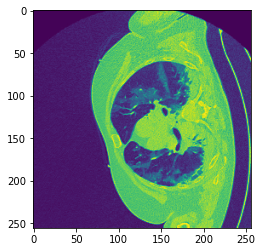

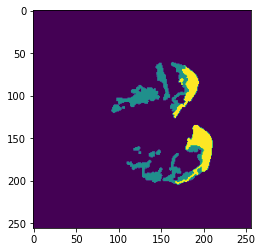

In [13]:
# Get a batch of training data
batch = next(iter(dataloaders['train']))
inputs = batch['image']
label = batch['label']
print(inputs.shape,type(inputs))
print(label.shape,type(label))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs.repeat(1,1,1,3))
#label = torchvision.utils.make_grid(label)
imshow(inputs[1,:,:,:].float().cpu())
#plt.show()
imshow(label[1,:,:].float().cpu())
#plt.show()

In [14]:
print(torch.unique(batch['label']))

tensor([0., 1., 2.], dtype=torch.float64)


In [15]:
dataloaders_tmp = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=len(image_datasets['train']),
                                             shuffle=True, num_workers=4),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=len(image_datasets['valid']),
                                             shuffle=True, num_workers=4)}
batch_tmp = next(iter(dataloaders_tmp['train']))
inputs_tmp = batch_tmp['image']
label_tmp = batch_tmp['label']
print(inputs_tmp.shape)

torch.Size([209, 1, 256, 256])


In [16]:
class_weight = torch.sqrt(1.0/(torch.bincount(batch_tmp['label'].reshape(-1).long()).float()))
class_weight = class_weight/class_weight.mean()
#class_weight[0] = 0.35
class_weight = class_weight.cuda()
#class_weight[3]=0
print(class_weight)
print('inv sqrt class_weight',class_weight)
criterion = nn.CrossEntropyLoss(class_weight)

tensor([0.1650, 1.4443, 1.3908], device='cuda:0')
inv sqrt class_weight tensor([0.1650, 1.4443, 1.3908], device='cuda:0')


In [17]:
batch_tmp_valid = next(iter(dataloaders_tmp['valid']))
class_weight_valid = torch.sqrt(1.0/(torch.bincount(batch_tmp_valid['label'].reshape(-1).long()).float()))
class_weight_valid = class_weight_valid/class_weight_valid.mean()
#class_weight[0] = 0.35
class_weight_valid = class_weight_valid.cuda()
#class_weight[3]=0
print(class_weight_valid)
print('inv sqrt class_weight',class_weight_valid)
criterion_valid = nn.CrossEntropyLoss(class_weight_valid)


tensor([0.1431, 0.8487, 2.0082], device='cuda:0')
inv sqrt class_weight tensor([0.1431, 0.8487, 2.0082], device='cuda:0')


In [18]:
# Experiment parameters
lr_find_epochs = 2
start_lr = 1e-7
end_lr = 0.1

In [19]:
# Set up the model, optimizer and loss function for the experiment
model = unet_2D()

#model.apply(init_weights)
model.cuda()
model.train()

optimizer = torch.optim.Adam(list(model.parameters()),start_lr)          #SGD(model.parameters(), start_lr)
#criterion = nn.CrossEntropyLoss()

/mnt/2tbhdd/kumar/notebooks/CovidSeg/networks_other_ozan.py:42: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
/mnt/2tbhdd/kumar/notebooks/CovidSeg/networks_other_ozan.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 1.0, 0.02)
/mnt/2tbhdd/kumar/notebooks/CovidSeg/networks_other_ozan.py:47: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


In [20]:
# LR function lambda
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( dataloaders["train"])))
scheduler = LambdaLR_N(optimizer, lr_lambda)

In [21]:
# Run the experiment 

lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05

for i in range(lr_find_epochs):
  print("epoch {}".format(i))
  for i, batch in enumerate(dataloaders['train']):
    
    # Send to device
    inputs = batch['image'].float().cuda()
    label = batch['label'].long().cuda()
        
    inputs,label = augmentAffine(inputs,label,0.075)

        
    output = model(inputs)#imgs[idx[:,iter],:,:,:])
         
    # Training mode and zero gradients
    model.train()
    optimizer.zero_grad()
    
    # Get outputs to calc loss
    outputs = model(inputs)
    loss = criterion(outputs, label)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_find_lr.append(lr_step)

    # smooth the loss
    if iter==0:
      lr_find_loss.append(loss)
    else:
      loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
      lr_find_loss.append(loss)
     
    iter += 1

epoch 0


/mnt/2tbhdd/kumar/miniconda3/envs/pydl/lib/python3.8/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/mnt/2tbhdd/kumar/miniconda3/envs/pydl/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


epoch 1


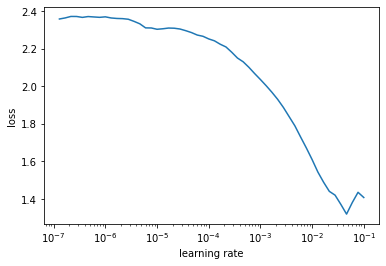

In [22]:
plt.ylabel("loss")
plt.xlabel("learning rate")
plt.xscale("log")
plt.plot(lr_find_lr, lr_find_loss)
plt.show()

In [23]:
#trainset = next(iter(dataloaders_tmp['train']))
#testset = next(iter(dataloaders_tmp['valid']))

In [24]:
net = unet_2D()
#net.apply(init_weights)
net.cuda()
net.train()
total_epocs_var = 500 #500

print(countParameters(net))

optimizer = optim.Adam(list(net.parameters()),lr=0.002)

# learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
#scheduler =optimizerCyclic.OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(dataloaders['train']), epochs=total_epocs_var)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0005, steps_per_epoch=len(dataloaders['train']), epochs=total_epocs_var)

lr_max = 9*10e-3
factor = 6
end_lr = lr_max

step_size = 4*len(dataloaders['train'])
#clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(dataloaders['train']), epochs=total_epocs_var)

847327


In [ ]:
train_loss = torch.zeros(total_epocs_var)/0
val_loss = torch.zeros(total_epocs_var)/0


run_dice = []  #torch.zeros(500)/0
run_dice2 = 0

for epoch_i in range(total_epocs_var):
    #idx = torch.randperm(9).view(3,3)
    net.train()
    train_loss[epoch_i] = 0.0
    i=0
    #dataset = trainset['image']
    #labels = trainset['label']
    
    #data_len = dataset.size(0)
    #idx_epoch = torch.randperm(data_len)[:data_len-data_len%batch_size].view(batch_size,-1)
    

    for i, batch in enumerate(dataloaders['train']):
    #for iter in range(10):
    #for iter in range(#idx_epoch.size(1)):
        #idx = idx_epoch[:,iter]

        optimizer.zero_grad()
        #inputs = dataset[idx].float().cuda()
        #label = labels[idx].long().cuda()
        
        inputs = batch['image'].float().cuda()
        label = batch['label'].long().cuda()
        
        inputs,label = augmentAffine(inputs,label,0.075)

        
        output = net(inputs)#imgs[idx[:,iter],:,:,:])
        
        #print(inputs.shape)
        #print(output.shape)
        #print(label.shape)
            
        loss = criterion(output,label)#segs[idx[:,iter],:,:])
        loss.backward()
        
        optimizer.step()
        #scheduler.step()
        
        train_loss[epoch_i] += loss.item()
        #print('train loss',train_loss[epoch])
        i = i +1
    
    #print('i',i)
    #print('train loss',train_loss[epoch])
    train_loss[epoch_i] /= i
    #print('train loss',train_loss[epoch])
        
    if(True):
        net.eval()
        with torch.no_grad():
            val_loss[epoch_i] = 0.0
            batch_dice = 0
            batch_dice_mean = 0
            i=0
            #dataset = testset['image']
            #labels = testset['label']
            #data_len = dataset.size(0)
            #idx_epoch = torch.randperm(data_len)[:data_len-data_len%batch_size].view(batch_size,-1)
            
            for i, batch in enumerate(dataloaders['valid']):
            #for iter in range(idx_epoch.size(1)):
                #idx = idx_epoch[:,iter]
                
                optimizer.zero_grad()
                
                #inputs = dataset[idx].float().cuda()
                #label = labels[idx].long().cuda()
                
                inputs = batch['image'].cuda()
                label = batch['label'].long().cuda()
        
                output = net(inputs.float())
                loss = criterion_valid(output,label)
                val_loss[epoch_i] += loss.item()
                
            
                d1 = dice_coeff(output.argmax(1), label, 3)
                
                batch_dice += d1
                #print('dl, batch dice',d1,batch_dice)
                i = i+1
                batch_dice_mean += d1.mean().cpu()
                #print('batch dice, batch dice mean',batch_dice,batch_dice_mean)
             
            #print('batch dice, batch dice mean',batch_dice,batch_dice_mean)
            val_loss[epoch_i]/=i
            batch_dice/=i
            batch_dice_mean/=i
            #print('Average batch dice, batch dice mean',batch_dice,batch_dice_mean)
            
            run_dice2+=batch_dice
            run_dice.append(batch_dice_mean)
            #run_dice[epoch//2] = batch_dice_mean/i
            
        if(epoch_i%25==5):
            print('Run Dice 2 All Labels Average',run_dice2/epoch_i)
            print('epoch',epoch_i,'train loss',train_loss[epoch_i], 'val loss',val_loss[epoch_i],'dice',run_dice[epoch_i])
            print('run_dice[epoch] Average',torch.tensor(run_dice).float().mean())
            
print('Run Dice 2 All Labels Average Final',run_dice2/total_epocs_var)

Run Dice 2 All Labels Average tensor([0.6513, 0.2173])
epoch 5 train loss tensor(0.2219) val loss tensor(0.2193) dice tensor(0.4218)
run_dice[epoch] Average tensor(0.3619)
Run Dice 2 All Labels Average tensor([0.5692, 0.2376])
epoch 30 train loss tensor(0.2524) val loss tensor(0.2867) dice tensor(0.3717)
run_dice[epoch] Average tensor(0.3904)
Run Dice 2 All Labels Average tensor([0.5742, 0.2353])
epoch 55 train loss tensor(0.1673) val loss tensor(0.3419) dice tensor(0.3244)
run_dice[epoch] Average tensor(0.3976)
Run Dice 2 All Labels Average tensor([0.5690, 0.2462])
epoch 80 train loss tensor(0.1533) val loss tensor(0.2898) dice tensor(0.4281)
run_dice[epoch] Average tensor(0.4026)
Run Dice 2 All Labels Average tensor([0.5690, 0.2535])
epoch 105 train loss tensor(0.1508) val loss tensor(0.2126) dice tensor(0.4525)
run_dice[epoch] Average tensor(0.4073)
Run Dice 2 All Labels Average tensor([0.5701, 0.2562])
epoch 130 train loss tensor(0.1378) val loss tensor(0.2325) dice tensor(0.5028)


In [ ]:
#print(run_dice)
torch.save(net, './Oz_Unet_CC_Models/run1_split0_net_oz_unet_500ep_randbatch8')

In [ ]:
print('Run Dice 2 All Labels Average',run_dice2/epoch_i)
print('epoch',epoch_i,'train loss',train_loss[epoch_i], 'val loss',val_loss[epoch_i],'dice',run_dice[epoch_i])
print('run_dice[epoch] Average',torch.tensor(run_dice).float().mean())

In [ ]:
print(total_epocs_var)

In [ ]:
epoc=range(total_epocs_var)
plt.plot(epoc,train_loss.cpu().numpy(),label='train_loss')
plt.plot(epoc,val_loss.cpu().numpy(),label='Val_Loss')
plt.legend()
plt.figure()
plt.show()
plt.plot(epoc,run_dice,label='Valid Dice')
#plt.plot(epoc,val_l,label='Val_loss')
plt.legend()
plt.figure()
plt.show()

In [ ]:
print(np.average(run_dice[400:total_epocs_var]))

In [ ]:
print(np.average(run_dice[300:400]))

In [ ]:
'''net.eval()
with torch.no_grad():
    output_test = net(img_test)
    d1 = dice_coeff(output_test.argmax(1), seg_test, 8)
run_dice[epoch//25] = d1.mean().cpu()
print('epoch',epoch,'loss',run_loss[epoch],'dice',d1.mean())

plt.imshow(output_test.argmax(1).squeeze().data.cpu().numpy())
plt.show()'''

In [ ]:
#torch.save(net.eval().cpu().state_dict(),'run1_split2_net_unet_500ep_randbatch16_statedict.pth')

In [ ]:
#torch.save(net.eval().cpu(),'run1_split2_net_unet_500ep_randbatch16_model.pth')

In [ ]:
#print(img_test.size())